In [183]:
using IntervalSets, ModelingToolkit
using Sophon
using Optimization, OptimizationOptimJL, OptimizationOptimisers

@parameters t, x
@variables u(..)
Dₜ = Differential(t)
Dₓ = Differential(x)
Dₓ² = Differential(x)^2
Dₓ³ = Differential(x)^3

ν = 0.0025
eqs = [Dₜ(u(t, x)) + Dₓ(u(t, x)) * u(t, x) + ν * Dₓ³(u(t, x)) ~ 0]

bcs = [u(0, x) ~ cospi(x), u(t, -1.0) ~ u(t, 1.0)]

domain = [t ∈ Interval(0.0, 1.0), x ∈ Interval(-1.0, 1.0)]

@named KdV = PDESystem(eqs, bcs, domain, [t, x], [u(t, x)])

PDESystem
Equations: Equation[0.0025Differential(x)(Differential(x)(Differential(x)(u(t, x)))) + Differential(x)(u(t, x))*u(t, x) + Differential(t)(u(t, x)) ~ 0]
Boundary Conditions: Equation[u(0, x) ~ cospi(x), u(t, -1.0) ~ u(t, 1.0)]
Domain: Symbolics.VarDomainPairing[Symbolics.VarDomainPairing(t, 0.0..1.0), Symbolics.VarDomainPairing(x, -1.0..1.0)]
Dependent Variables: Num[u(t, x)]
Independent Variables: Num[t, x]
Parameters: SciMLBase.NullParameters()
Default Parameter ValuesDict{Any, Any}()

In [184]:
chain = Siren(2, 1; hidden_dims=16, num_layers=5, omega=1f0)
pinn = PINN(chain)
sampler = BetaRandomSampler(2000, 300)
strategy = NonAdaptiveTraining(1, (50, 20))
prob = Sophon.discretize(KdV, pinn, sampler, strategy)

OptimizationProblem. In-place: true
u0: ComponentVector{Float64}(layer_1 = (weight = [0.16986340284347534 0.39173775911331177; -0.07234025001525879 0.3220815658569336; … ; 0.05540889501571655 0.4812222719192505; -0.4672316908836365 0.19320785999298096], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_2 = (weight = [0.46756792068481445 0.19510889053344727 … -0.48692846298217773 -0.4182276129722595; 0.14363114535808563 0.284487247467041 … 0.5434563159942627 0.1069716140627861; … ; 0.1852821558713913 0.0706220492720604 … -0.36497610807418823 -0.16941118240356445; 0.6113330721855164 0.19053329527378082 … 0.4349452555179596 -0.3289404511451721], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_3 = (weight = [0.0723247155547142 -0.11262396723031998 … 0.1252007782459259 -0.44305354356765747; 0.3161363899707794 -0.014808584935963154 … 0.04366873949766159 0.029462262988090515; … ; 0.05947078764438629 -0.21238547563552856 … 0.01696348562836647 0.4709751307964325; -0.5365021228790283 0.5387070178985596 … 0.28

In [185]:
i = 0
function callback(p, l)
    global i
    i%100==0 && println("Loss: $l")
    i += 1
    return false
end

res = Optimization.solve(prob, BFGS(); maxiters=1000, callback=callback)

Loss: 144.5347626494427


Loss: 0.14014935510502968


Loss: 0.07304825759526813


Loss: 0.024707435424543824


Loss: 0.006193188503048891


Loss: 0.0019371491526140123


Loss: 0.0010643287333432444


Loss: 0.0006055285564480052


Loss: 0.00036436156684818835


Loss: 0.0002491880359985412


Loss: 0.00017560492623800887


u: ComponentVector{Float64}(layer_1 = (weight = [0.34629364411337016 0.22764387072889966; 0.25759132912470467 0.38801960073878394; … ; 0.2512535048118634 0.6819208836087822; -0.6447290990171614 1.6657317605035022], bias = [-0.17873474920905552; -0.07553966728597646; … ; -0.25366575501387956; -0.2689891022008724;;]), layer_2 = (weight = [0.590924796549307 0.3553548457539984 … -0.340625090328021 -0.3898229359132666; 0.6185476140928087 0.4812243624569212 … 0.8479013961100955 -0.12268549769444698; … ; -0.006923187357007158 -0.035669738973683876 … -0.29296565139661834 0.2730740115515959; 0.5739881222455239 0.10907189270394532 … 0.3852089178543719 -0.42017704348260715], bias = [0.1810480652906728; 0.05298504486281009; … ; -0.15876100183293296; 0.3833491476139218;;]), layer_3 = (weight = [0.1971323037468086 -0.34941483589646255 … 0.00396139964021509 -0.34772550610092895; 0.31256350936374644 0.09697329811712034 … 0.03487319620304811 0.22155195505587677; … ; -0.11865267605396657 -0.134540599540

In [186]:
using MAT
data = matread("KdV.mat")

usol = data["uu"]

# Grid
t_star = vec(data["tt"])
x_star = vec(data["x"]);

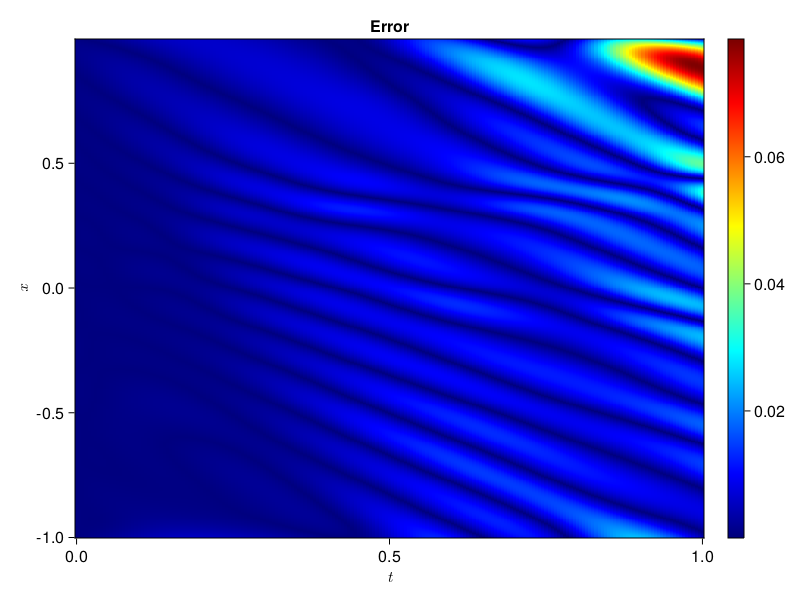

In [187]:
using CairoMakie, MakiePublication

phi = pinn.phi
u_pred = [sum(pinn.phi([t, x], res.u)) for t in t_star, x in x_star]
fig, ax, hm = heatmap(t_star, x_star, abs.(u_pred .- usol');
                      axis=(xlabel=L"t", ylabel=L"x", title="Error"), colormap=:jet)
Colorbar(fig[:, end + 1], hm)
fig

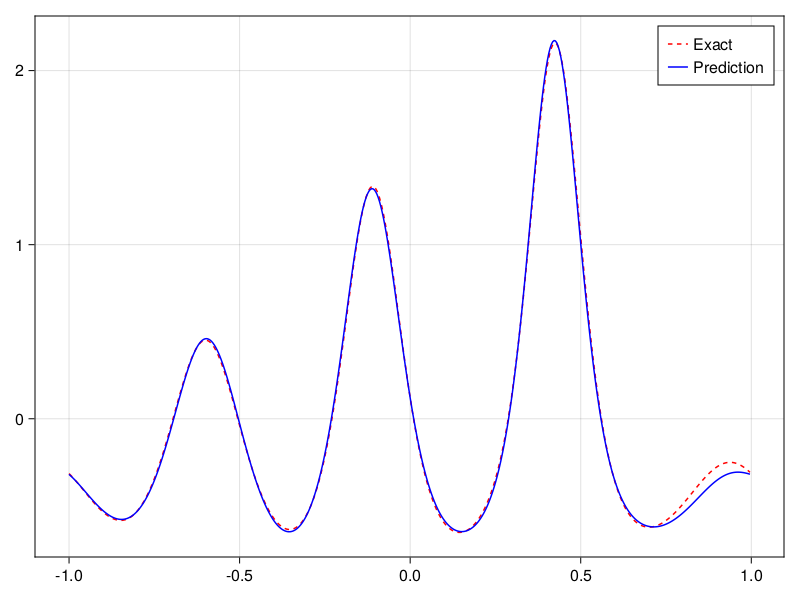

In [188]:
fig = Figure()
axis = Axis(fig[1, 1])
lines!(x_star, usol[:, end], label="Exact", color=:red,  linestyle = :dash)
lines!(x_star, u_pred[end, :], label="Prediction", color=:blue)
axislegend(axis)
fig

Loss: 0.0004648332259526962


Loss: 0.00021891248498343916


Loss: 0.0001515467079770863


Loss: 0.00011507703764595639


Loss: 9.109692464970581e-5


Loss: 7.477828169606636e-5


Loss: 6.21629807138715e-5


Loss: 5.1401220042119194e-5


Loss: 4.3414233643748434e-5


Loss: 3.641719672270508e-5


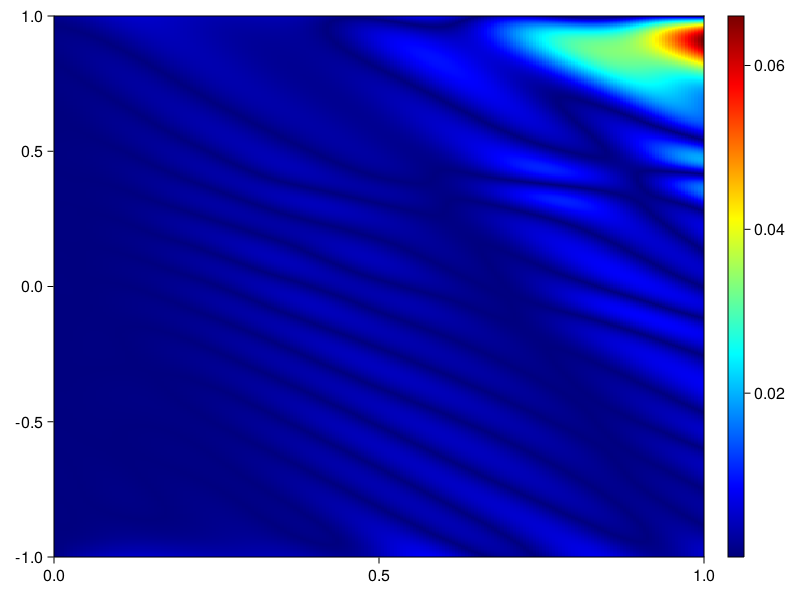

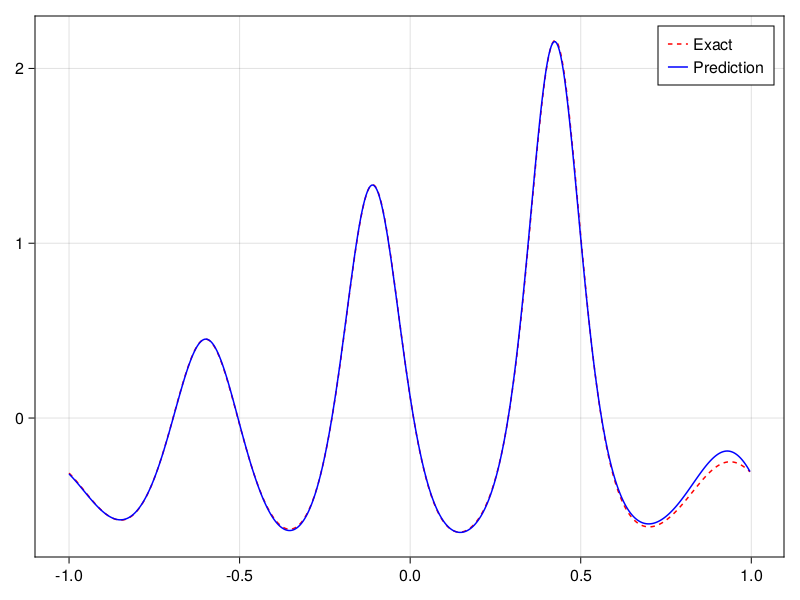

Loss: 3.021205378334537e-5


Loss: 5.558614164330554e-5


Loss: 3.6036570374602114e-5


Loss: 2.913995317073963e-5


Loss: 2.3574851968901662e-5


Loss: 1.9749988823233472e-5


Loss: 1.708731900918045e-5


Loss: 1.4949869891666895e-5


Loss: 1.3090368953358034e-5


Loss: 1.1480990652511872e-5


Loss: 1.0305771104236004e-5


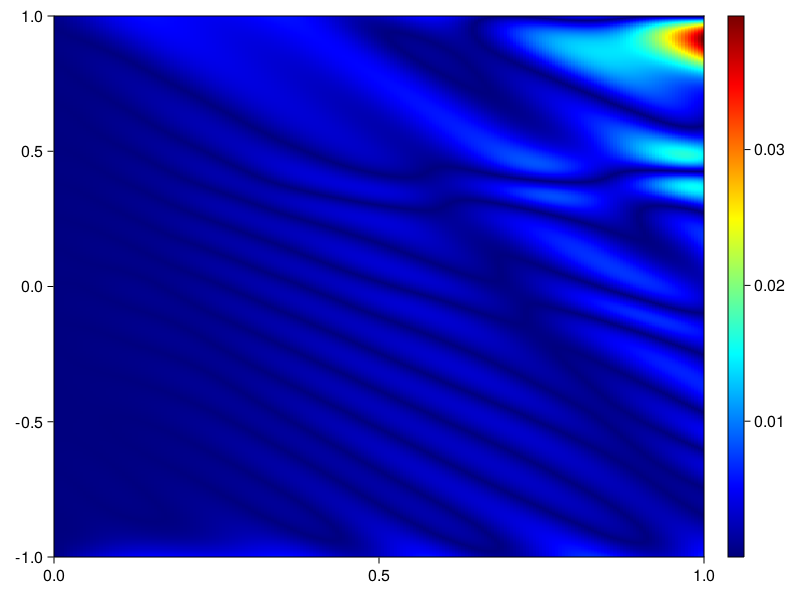

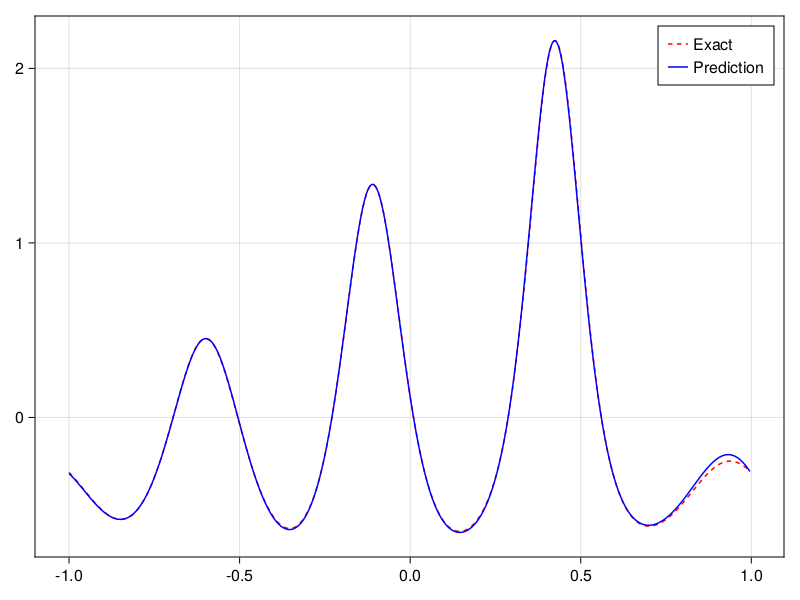

Loss: 9.323557113025992e-6


Loss: 3.9682902662094516e-5


Loss: 1.3640061381197356e-5


Loss: 1.0910488961111194e-5


Loss: 9.633323505034516e-6


Loss: 8.401500638885072e-6


Loss: 7.405561751764807e-6


Loss: 6.481449166019951e-6


Loss: 5.836364292771955e-6


Loss: 5.3674780879775765e-6


Loss: 4.941815229674091e-6


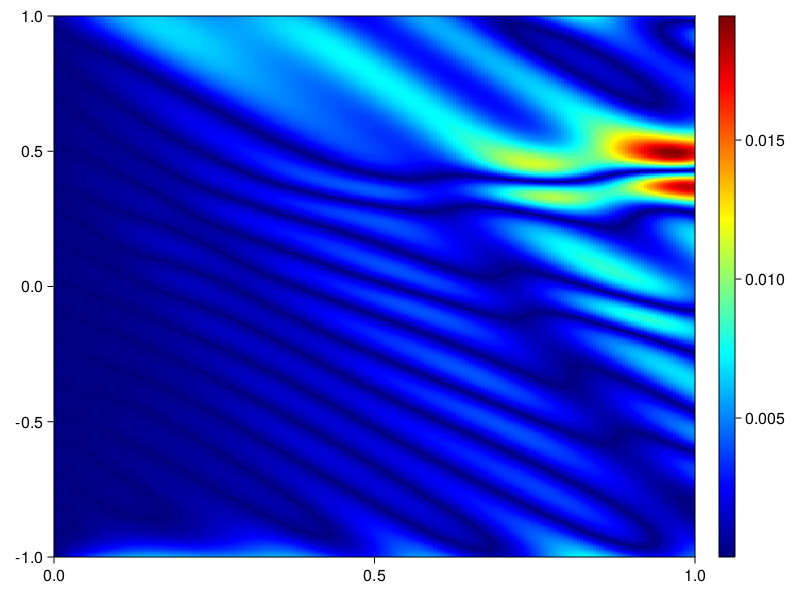

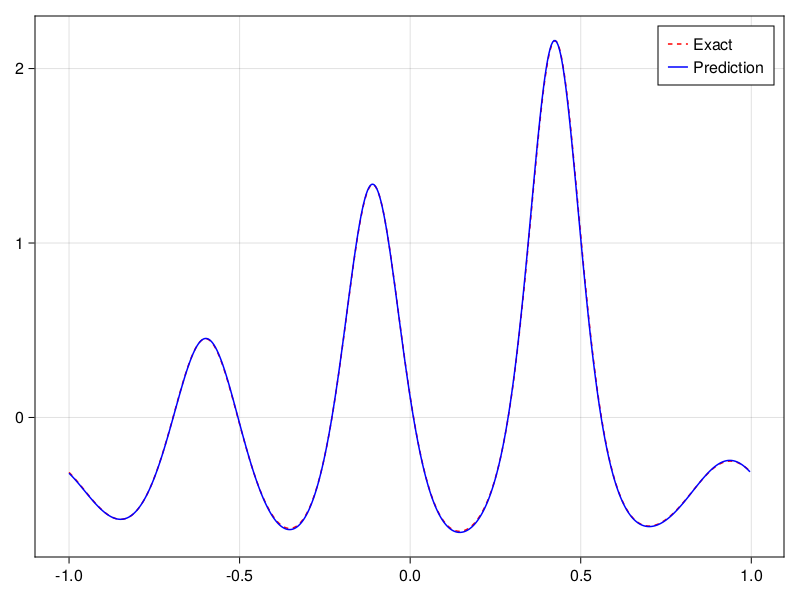

Loss: 4.569646237367988e-6


In [189]:
for α in [0.6, 0.8, 1.0] 
    i=0
    sampler = remake(sampler; α=α)
    data = Sophon.sample(KdV, sampler)
    prob = remake(prob; p=data, u0=res.u)
    res = Optimization.solve(prob, BFGS(); maxiters=1000, callback=callback)

    u_pred = [sum(pinn.phi([t, x], res.u)) for t in t_star, x in x_star]
    fig, ax, hm = heatmap(ts, xs, abs.(usol' .- u_pred), colormap=:jet)
    Colorbar(fig[:, end + 1], hm)
    display(fig)

    fig = Figure()
    axis = Axis(fig[1, 1])
    lines!(x_star, usol[:, end], label="Exact", color=:red,  linestyle = :dash)
    lines!(x_star, u_pred[end, :], label="Prediction", color=:blue)
    axislegend(axis)
    display(fig)
end


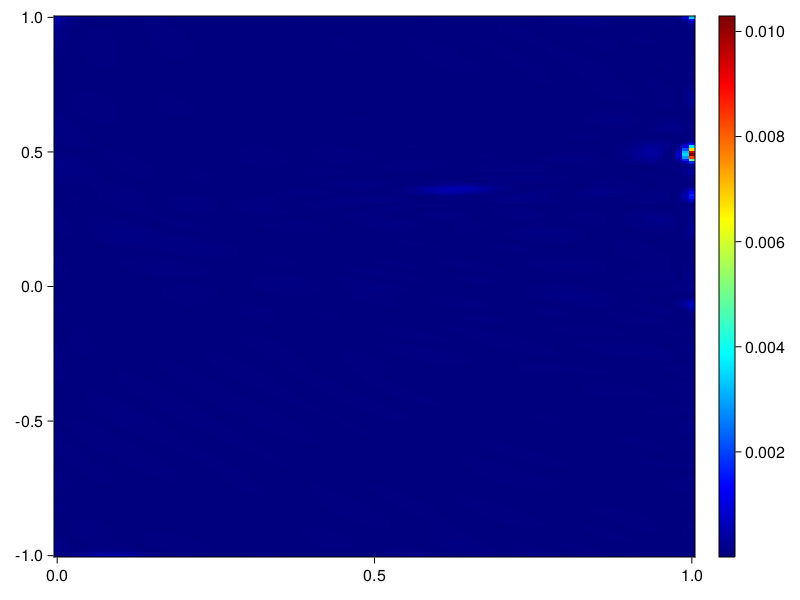

In [195]:
residual = [sum(abs2, Sophon.residual_function_1([t, x], res.u)) for t in ts, x in xs]

fig, ax, hm = heatmap(ts, xs, residual, colormap=:jet)
Colorbar(fig[:, end + 1], hm)
fig

In [201]:
res.objective

3.975217379249699e-6

In [205]:
using JLD2
jldsave("KdV.jld2"; pde=KdV, phi=phi, res=res, prob=prob)